# FAKE NEWS DETECTION MODEL

### Loading Dataset from .csv file

The following project was inspired by *kaggle.com*, and the dataset used for modelling was from their website. Our original dataset, *original_news.csv*, contains 4 columns. These columns consist of an ***ID*** number, the ***title*** of the new article, the ***text*** of the whole article and the target ***label*** for modelling purposed. We will proceed with the importing of the appropriate packages.

In [506]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pyplot
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import csv
import os
import ast
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

Next, we shall now load the original dataset into python. The head of the pandas dataset is presented below. 

In [318]:
dataset = pd.read_csv('original_news.csv') #create pandas dataframe using .csv file
display(dataset.head()) #display top 5 entries

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Before we proceed, we must ensure that all duplicates are removes from the dataset. On the *kaggle* website, where I obtained the dataset, the page corresponding to this data contained a brief summary of the whole dataset. Viewing this I discovered that multiple datapoints existed with identical values. In order to avoid the possibility of oversaturating out predictive models with multiple datapoint of identical values, we must remove them. Once this simply bit of data cleaning is finished, we may proceed to explore our data. The number of duplicate data points removed is 29.

In [135]:
dataset = dataset.drop_duplicates(subset = ['title','text']) #remove duplicates if they share the same values for 'title' AND 'text'

## Exploratory Data Analysis

To further expand the search for possible correlations to create a more reliable predictive model for this project, we shall introduce some more metrics for each item in our dataframe. We shall introduce the features, ***title_word_count*** and ***text_word_count***. As these names may suggest, they are simply the number of words present within the ***title*** and ***text*** respectively.

In [136]:
dataset['title_word_count'] = dataset['title'].str.split().apply(len) #from 'title', convert to string, split string to list and apply length to list
dataset['text_word_count'] = dataset['text'].str.split().apply(len) #from 'text', convert to string, split string to list and apply length to list

display(dataset.head())

,Unnamed: 0,title,text,label,title_word_count,text_word_count
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1296
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,431
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,317


These new metrics that we have evaluated are now prime subjects to perform some basic exploratory data analysis upon them to discover how each data series is distributed across our whole dataset. For now we shall create histograms for each group of data to discover a distribution for each and evaluate their basic properties, such as their mean and variance. 

In [138]:
def mean_and_variance(input_dataset,column_label):
    data = input_dataset[column_label]
    mean = sum(data)/len(data)
    variance = np.var(data)
    print(f'Mean of \'{column_label}\' data: {mean},\n')
    print(f'Variance of \'{column_label}\' data: {variance}.\n')
    return mean, variance

title_word_count_metrics = mean_and_variance(dataset,'title_word_count')
text_word_count_metrics = mean_and_variance(dataset,'text_word_count')

Mean of 'title_word_count' data: 10.495876942594355,

Variance of 'title_word_count' data: 15.879542150413489.

Mean of 'text_word_count' data: 776.3495084046939,

Variance of 'text_word_count' data: 732167.4376282074.



Text(0, 0.5, 'No. of Datapoints')

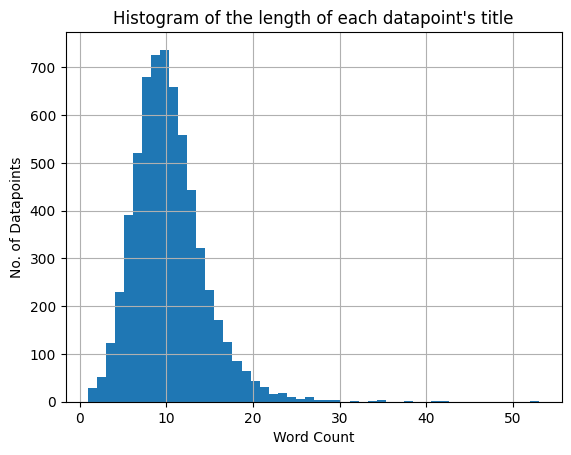

In [139]:
dataset['title_word_count'].hist(bins=50) #histogram of bin number equal to 50 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s title') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label

Text(0, 0.5, 'No. of Datapoints')

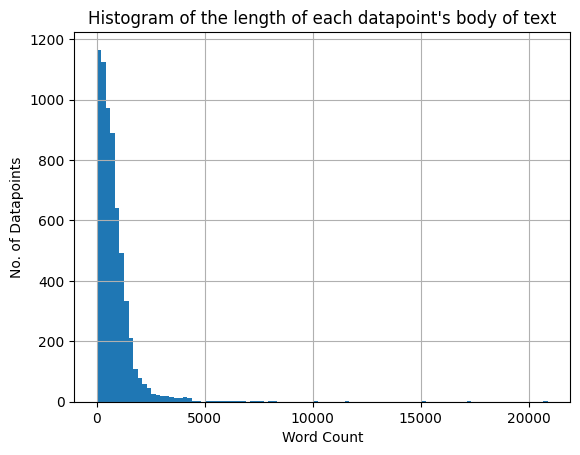

In [140]:
dataset['text_word_count'].hist(bins=100) #histogram of bin number equal to 100 from 'title_word_count' data
pyplot.title('Histogram of the length of each datapoint\'s body of text') #title of histogram
pyplot.xlabel('Word Count') #x-axis label
pyplot.ylabel('No. of Datapoints') #y-axis label

The mean and variance of the ***title_word_count*** data seem relatively normal. This is reinforced when observing the histogram of this data. The distribution peaks around the mean, roughly, and the spread of data seems reasonable, if we exclude the fact that our variable cannot be negative in value. However,we start to see irregularities when observing the metrics for the ***text_word_count*** data. The mean again seems relatively standard when compared with the histogram. However, the variance is extremely high. Obervation on the respective histogram revelas that there exists numerious data point where the number of words in the main body of text of the new article exceed 10,000 words! This will naturally overwhelm the variance value with our mean being relatively so small compared. All the datapoints that exceed this 10,000 word count margin are shown below.

In [141]:
display(dataset[dataset['text_word_count'] > 10000]) #show all extreme values for 'text_word_count' length

,Unnamed: 0,title,text,label,title_word_count,text_word_count
536,9618,President Putin Asks US To Stop Provoking Russia,Here is President Putin’s speech at Valdai Put...,FAKE,8,11662
1359,5604,Benny Morris’s Untenable Denial of the Ethnic ...,References The Debate \nIt started when Daniel...,FAKE,10,15199
3436,5765,Re: It Is Now Mathematically Impossible To Pay...,It Is Now Mathematically Impossible To Pay Off...,FAKE,13,17332
3685,8441,Re: America Has Become A Lawless Nation – Hill...,America Has Become A Lawless Nation – Hillary ...,FAKE,15,10090
4733,7910,Re: Why Are So Many People Choosing To Leave T...,Why Are So Many People Choosing To Leave The U...,FAKE,13,20891


From this we can make our first discovery about the dataset. Every data point that exceeds the 10,000 word count is classified as **FAKE**. We can use this observation later whose we have developed our first predictive models to see if they have also observed this trend and used this. An observation like this would work incredibly well in a modelling process such as a *decision tree* model. We could now do something smilar with the ***title_word_count*** now to see if any patterns like this can be discovered. Let us ask if data points with ***title_word_count*** values exceeding 30 are typically classified as **FAKE**.

In [142]:
display(dataset[dataset['title_word_count'] >= 30])

,Unnamed: 0,title,text,label,title_word_count,text_word_count
261,7892,Comment on Breaking: CDC Blocks Testimony of T...,Have you heard of Dr. William Thompson? If y...,FAKE,35,919
436,6329,Muslims regularly use “Inshallah” (“God Willin...,BNI Store Nov 5 2016 Muslims regularly use “In...,FAKE,30,665
1041,5939,Comment on The Science is “Overwhelming At Thi...,This ordinance is a big step forwards by cre...,FAKE,34,2513
1073,7560,Comment on ‘Voting Is Rigged & Used To Pacify ...,Share on Facebook Share on Twitter “This is th...,FAKE,38,1360
1208,5420,12 and 63-minute videos: Donald Trump connects...,"Posted on November 7, 2016 by Carl Herman \nJo...",FAKE,35,1421
1562,7769,Comment on Canadian Air Force Pilot Snaps A Pi...,Share on Facebook Share on Twitter “If it does...,FAKE,32,1077
1580,6031,Comment on Hillary Clinton failed to disclose ...,DCG | 2 Comments \nRules are for little peop...,FAKE,42,730
1663,9064,"Life: If You Love Enamel Pins, You’ll Love Thi...","Email If you can’t get enough enamel pins, the...",FAKE,53,375
2763,8341,Comment on Shocking Insinuation About Carl Sag...,Share on Facebook Share on Twitter A few years...,FAKE,32,3009
3607,6321,Queen Elizabeth II owns every dolphin in Brita...,Email \nQueen Elizabeth II is not like you and...,FAKE,30,2887


As we can see, all 15 data points that have title lengths that exceed or are equal to 30 words are all classified as **FAKE**. This can also be used to determine the success of any models that we evaluate in the future. These finds give us promise that correlations exist within the dataset to allow us to create a reliable prodictive model. Now that we have these findings, we are presented with another question that must be asked; Is there a need for the ***title*** and ***text*** data now? Have we extracted all infomation that may prove usful for our model? No. There still exists relavent information within these string data values. For instance, two of the joint most numerius data values associated with the *title* column are 'OnPolitics | 's politics blog' and 'Michael Moore Owes Me $4.99'. When we display all their respective datapoint out we observe that even though they have the same amount of ***title_word_count*** value, their ***label*** values are mutual exclusive from one another.

Text(0.5, 1.0, 'Scatter plot for title/text pairs')

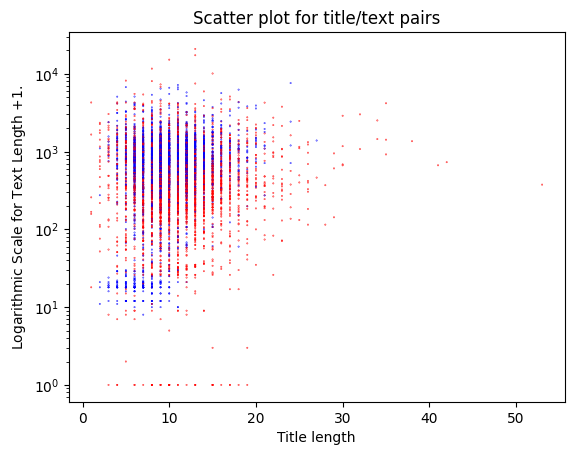

In [264]:
colour = {'REAL': 'blue', 'FAKE': 'red'}
scatter = pyplot.scatter(dataset['title_word_count'],dataset['text_word_count']+1, c = dataset['label'].map(colour), s=0.4, marker='.')
pyplot.xlabel('Title length')
pyplot.ylabel('Logarithmic Scale for Text Length $+ 1$.')
pyplot.yscale('log')
pyplot.title('Scatter plot for title/text pairs')

As we can see from the scatter plot above, some logic is present regarding determining **FAKE** and **REAL** news. Outlier datapoints where ***title_Word_count*** and ***text_word_count*** is either too high or too low are typically labels as **FAKE**. However, a closed form structural review for all datapoints still eludes us. **REAL** and **FAKE** datapoints cluster around eachother, so we can conclude that evaluating just the word count for the tile and the main text of each news article is not enough to reliable predict when the datapoint is within this cluster. So we shall now implement a new metric for our data. We shall implement a sentiment analysis model to out datapoints to get a metric of how possitive or negative an article is. Perhaps a negative article is more likely to be fake than real.

In [243]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #tokenizer converts text into series of numerical values
sentiment_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') #load pretrained sentiment model 

def sentiment_score(text): #define function to get sentiment score from model
    tokens = tokenizer.encode(text,return_tensors='pt') #tokenizer encodes given text into numerical values, returned in a pytorch tensor
    output = sentiment_model(tokens) #feed tokenizer data into model
    return int(torch.argmax(output.logits))+1 #convert output array into scores 1,2,3,4 and 5

dataset['title_sentiment_score'] = dataset['title'].apply(lambda x: sentiment_score(x)) #apply function to all title data
dataset['text_sentiment_score'] = dataset['text'].apply(lambda x: sentiment_score(x[:512])) #sentiment model is limited with how many tokens it can process at one time, specifically it is 512, so using only 512st words in text for evaluating

display(dataset.head())

,Unnamed: 0,title,text,label,title_word_count,text_word_count,title_sentiment_score,text_sentiment_score
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1296,5,4
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446,1,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,431,4,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404,1,1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,317,4,4


In [310]:
def save_csv_data(dataset):
    dataset.to_csv('cleaned_news.csv',index=False)
    return

save_csv_data(dataset)

In [344]:
title_ss_array = dataset['title_sentiment_score']
text_ss_array = dataset['text_sentiment_score']
title_lengths = dataset['title_word_count']
text_lengths = dataset['text_word_count']

r = np.corrcoef([title_lengths, text_lengths, title_ss_array, text_ss_array]) #Correlation-Coefficient Matrix of all desired variables

print(f'The Correlation-Coefficient Matrix for our 4 evaluated features:\n {r}, \n')

print(f'Correlation-Coefficient between our sentiment scores: {r[3,2]}, \n')

print(f'Correlation-Coefficient between title and text word count: {r[1,0]}.')

The Correlation-Coefficient Matrix for our 4 evaluated features:
 [[ 1.          0.03668925 -0.12064946 -0.07445042]
 [ 0.03668925  1.          0.04231625  0.03485658]
 [-0.12064946  0.04231625  1.          0.2874482 ]
 [-0.07445042  0.03485658  0.2874482   1.        ]], 

Correlation-Coefficient between our sentiment scores: 0.2874481953331301, 

Correlation-Coefficient between title and text word count: 0.036689254710973014.


The above correlation-coefficients yield the desired values. The magnitutde of every correlation coefficient between each feature does not exceed $0.3$, meaning that there does not exist any significant correlation between our intended numerical features for predictive models. This is what we desire. If our features are too correlated with each other, then our models are suseptible to overfitting to data that does not contribute any new insight into our models. What we desire, is for features to correlate with the target label (which we will discover via modelling) and that they arre appropriatly chosen features for our label (since they are all derived directly from the text data which encompasses the text's length and, in a sense, meaning beind the words we can be safe in calling them appropriate for our use).

This sentiment model scores using a scale from 1 to 5, with 1 corresponding with a negative sentiment and 5 being a positive sentiment. However, we have had to make a concession regarding the ***text*** data when evaluating it's sentiment score. Due to limitations with the sentiment model we are using, only the first 512 tokens of text can be used to assess the whole text's sentiment score. This may lead to sentiment scores not reflecting the true score of a body of text, but typically the beginning of an article sets a specific tone for the remainder of the text. This could be in the for or a intorduction which goes over what will be discussed or if its simply stating the purpose of the text. So for our analysis, we will have to assume the following: **The sentiment score for the text for each datapoint remains constant through the text itself**. We will perform this sentiment analysis on both the ***title*** and ***text***. The motivation behind this is that correlation may exist between the ***label*** and the difference in sentiment score between the title of an article and the main body of text, as a form of *click-baiting*. Furthermore, we want to see if our hypothesis is true that negatively sentimented articles are more likely to be ***FAKE***. We could also assess whether extreme sendiment scores on either side of neutral (1 or 5) correlate with labelling articles fake or not, to play to a specific audiance's emotions about a specific issue to get more view.

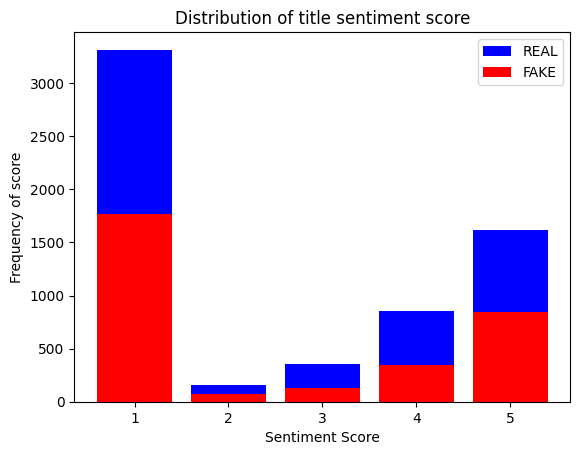

In [281]:
classes = [1,2,3,4,5] 
real_scores = []
fake_scores = []
for score in range(1,6,1):
    real_scores.append(len(dataset[(dataset['title_sentiment_score'] == score) & (dataset['label'] == 'REAL')]))
    fake_scores.append(len(dataset[(dataset['title_sentiment_score'] == score) & (dataset['label'] == 'FAKE')]))

fig, ax = pyplot.subplots()

for item in range(len(real_scores)):
    real_scores[item] = fake_scores[item] + real_scores[item]

ax.bar(classes,real_scores,label='REAL',color='blue')
ax.bar(classes,fake_scores,label='FAKE',color='red')

ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency of score')
ax.set_title('Distribution of title sentiment score')
ax.legend()

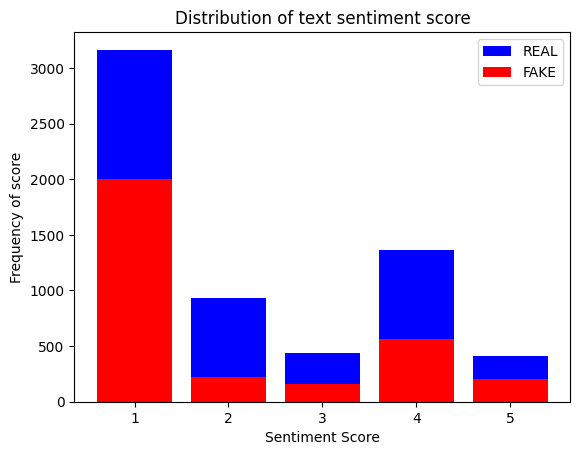

In [282]:
classes = [1,2,3,4,5] 
real_scores = []
fake_scores = []
for score in range(1,6,1):
    real_scores.append(len(dataset[(dataset['text_sentiment_score'] == score) & (dataset['label'] == 'REAL')]))
    fake_scores.append(len(dataset[(dataset['text_sentiment_score'] == score) & (dataset['label'] == 'FAKE')]))

fig, ax = pyplot.subplots()

for item in range(len(real_scores)):
    real_scores[item] = fake_scores[item] + real_scores[item]

ax.bar(classes,real_scores,label='REAL',color='blue')
ax.bar(classes,fake_scores,label='FAKE',color='red')

ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency of score')
ax.set_title('Distribution of text sentiment score')
ax.legend()

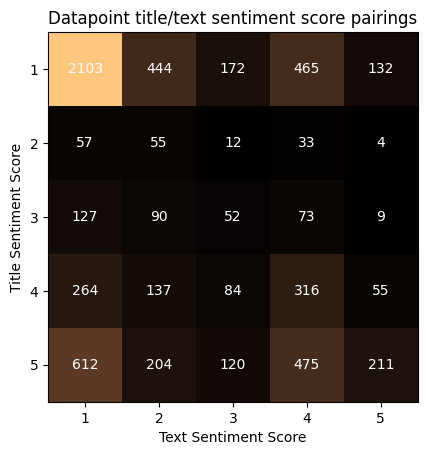

In [306]:
title_score_classes = ['1','2','3','4','5']
text_score_classes = ['1','2','3','4','5']

f = lambda i, j: len(dataset[(dataset['title_sentiment_score'] == i+1) & (dataset['text_sentiment_score'] == j+1)])
score_matrix = np.fromfunction(np.vectorize(f), (5,5), dtype=int)

fig, ax = pyplot.subplots()
im = ax.imshow(score_matrix,cmap = 'copper')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(title_score_classes)), labels=title_score_classes)
ax.set_yticks(np.arange(len(text_score_classes)), labels=text_score_classes)

# Loop over data dimensions and create text annotations.
for i in range(len(title_score_classes)):
    for j in range(len(text_score_classes)):
        text = ax.text(j, i, score_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Datapoint title/text sentiment score pairings")
pyplot.xlabel('Text Sentiment Score')
pyplot.ylabel('Title Sentiment Score')
pyplot.show()

Note that a significant proportion of sentimental scores for both title and text are valued at 1. This can be explained as news outlets reference to use negative language to attract the attention of viewers so as to gain an increase in footfall on their respective websites. However, we must be ever aware of the assumption we have made regarding the sentiment score of the text of the article. We may also be experiencing an inflation in negatively sentimented scores due to articles possibly being written more negatively than what the whole article actually reflects to keep viewers reading. But, the proportion of **REAL** and **FAKE** new articles across all scores for both title and text data is promising for us and our models when training. We do not want to accidentaly train our models on data that is entirely fake for a certain sentiment score, this would lead to our models creating an untrue correlation and would yield unfavourable predictions. 

### Topic Modelling

LDA? BERTopic?

## Modelling

### Baseline models

The gauge the success of our models, we will present a baseline model to compare future classification models with. The standard baseline model that we could us takes the form of a uniform random coin-toss. Since our models will be determining the ***label*** of a data point, which can only take the classes **REAL** or **FAKE**. Thus, a model that chooses between these two classes with equal probability can be expected to get an accuracy score of $50$%. So for future models that we derive, if they are an improvement upon an accuracy score of $50$%, we could begin to consider the effectiveness of this model.

### Logistic Regression

Now that we have our data prepared, we shall begin by splitting our data into the training, validation and test sets, each with the appropriate features and labels. After the partition of for our modeling, we shall implement the Logistic Regression along with a Grid Search to fins the optimal hyperparameters from a given parameter directory. The best parameters for our model and the corresponding model metrics are presented below. 

In [383]:
dataset = pd.read_csv('cleaned_news.csv')

X = dataset[['title_word_count','text_word_count','title_sentiment_score','text_sentiment_score']]
y = dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) #to create a 60-20-20 split in data sets

MODEL METRICS
-------------

Model Parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}.

Precision Score: 0.614114231690333,
Recall Score: 0.6137985725614592,
F1 Score: 0.6138170312849305,
Accuracy Score: 0.6137985725614592,
Confusion Matrix:


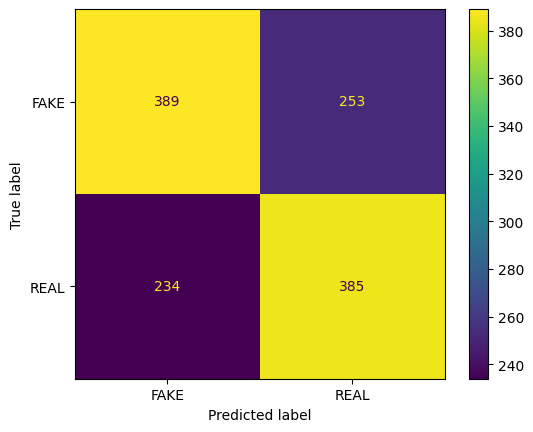

In [455]:
def run_model(model_class, hyper_dict):
    model = model_class() #logistic model
    gridsearch = GridSearchCV(model,hyper_dict) #perform gridsearch for the all model settings
    fit_model = gridsearch.fit(X_train,y_train) #fit using training sat
    best_estimator = fit_model.best_estimator_ #best estimator from all permutations of settings

    prediction = best_estimator.predict(X_valid) #predict using validation set

    precision_value = precision_score(prediction,y_valid,average='weighted',zero_division=0) #precision score
    recall_value = recall_score(prediction,y_valid,average='weighted',zero_division=0) #recall score
    f1_value = f1_score(prediction,y_valid,average='weighted') #f1 score
    accuracy_score = best_estimator.score(X_valid,y_valid) #accuracy score
    cf = confusion_matrix(prediction,y_valid) #confusion matrix
    cf_plot = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = best_estimator.classes_) #class to display confusion matirx

    metric_dict = {
        'Precision Score': precision_value,
        'Recall Score': recall_value,
        'F1 Score': f1_value,
        'Accuracy': accuracy_score
    }

    print(f'MODEL METRICS')
    print('-------------\n')
    print(f'Model Parameters: {best_estimator.get_params()}.\n')
    print(f'Precision Score: {precision_value},\nRecall Score: {recall_value},\nF1 Score: {f1_value},\nAccuracy Score: {accuracy_score},')
    print(f'Confusion Matrix:')
    display(cf_plot.plot())
    
    dir_name = type(model_class()).__name__ #return name of model from class
    try:
        os.mkdir(f'{dir_name}/')
    except:
        pass
    joblib.dump(best_estimator,f"{dir_name}/model")

    with open(f"{dir_name}/paramters.json", "w") as f:
        json.dump(best_estimator.get_params(), f)

    with open(f"{dir_name}/metrics.json", "w") as f:
        json.dump(metric_dict, f)
    
    if 'confusion_matrix.png' in os.listdir(f'{dir_name}'):
        os.remove(f'{dir_name}/confusion_matrix.png')
        cf_plot.figure_.savefig(f'{dir_name}/confusion_matrix.png')
    return

hyper_dict = {
    'C': [1,0.5,0.1],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky','saga','sag'],# excluding 'newton-cg' solver as its unable to converge to best fit line
    'multi_class': ['auto','ovr'], #excluding multinomial due to incompatability with 'liblinear' solver
    'max_iter': [1000000] #to remove warning messages
}

run_model(LogisticRegression,hyper_dict)

Compared to our theoretical baseline model, we see an increase in the accuracy for correct predictions by about $11.4$%, with the overall accuracy of our logistic regression model at $61.38$%. We can also notice that the recall and precision scores for our model are very similar, showing that our model holds no favouratism towards false-positive or false-negative. This is reflected in confusion matrix displayed above. The values for correct and incorrect predictions for each class is very similar. This also reassures us that the number of real and fake news articles used to fit and assess the model are roughly split 50-50. This exposer to equal amounts of each class causes our model to create healthy connections with the data which gives our model a better chance of avoiding predictions incorrectly due to a lack of training data of that class.

### Decision Tree

MODEL METRICS
-------------

Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}.

Precision Score: 0.6336241078509119,
Recall Score: 0.6336241078509119,
F1 Score: 0.6336241078509119,
Accuracy Score: 0.6336241078509119,
Confusion Matrix:


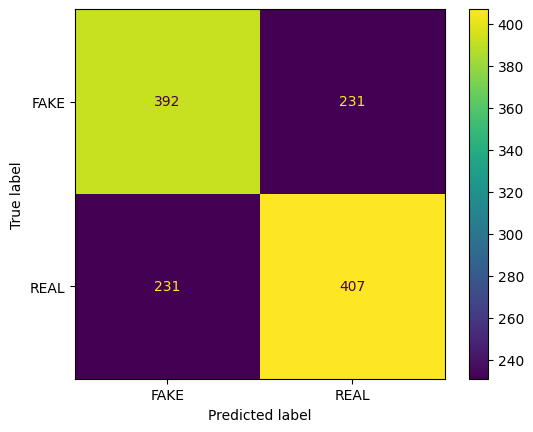

In [445]:
hyper_dict = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best','random'],
    'min_samples_split': [1, 2, 3],
    'random_state': [42]
}

run_model(DecisionTreeClassifier,hyper_dict) #random_state given to allow for reproducability of result.

With our Decision tree model, we can clearly that this model is objectively better than the logistic regression model. For instance, the accuracy of our logistic model was $61.38$%, whereas our Decision Tree model holds an accuracy of $63.36$%. Furthermore, all other metrics to evaluate the succes of our model yields better values. This improvement can clearly be seen within the confusion matrices of both models. In all diagonal entries, we see an increase in these number (remember that these represent the correct predictions). And in the other cells of the matrix, we see a decrease in all of them (the number representing the number of incorrect predictions).

### Random Forest

MODEL METRICS
-------------

Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}.

Precision Score: 0.6688103534007582,
Recall Score: 0.6677240285487708,
F1 Score: 0.6679612554137803,
Accuracy Score: 0.6677240285487708,
Confusion Matrix:


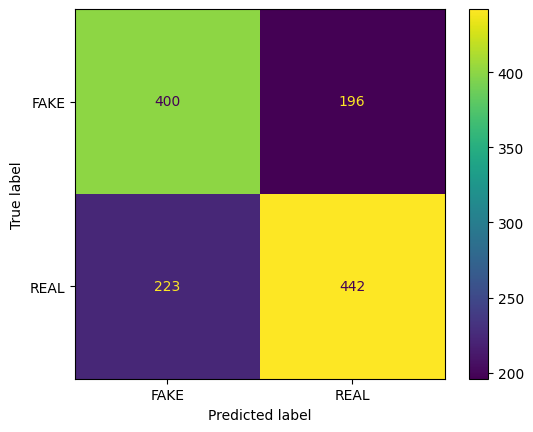

In [446]:
hyper_dict = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini','entropy','log_loss'],
    'min_samples_split': [1, 2, 3],
    'random_state': [42]
}

run_model(RandomForestClassifier,hyper_dict)

### Gradient Boosting

MODEL METRICS
-------------

Model Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}.

Precision Score: 0.71725452377681,
Recall Score: 0.7168913560666138,
F1 Score: 0.7169715204300158,
Accuracy Score: 0.7168913560666138,
Confusion Matrix:


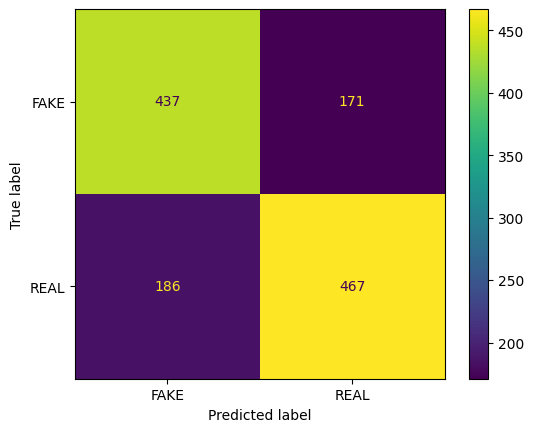

In [447]:
hyper_dict = {
    'loss': ['log_loss','exponential'],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'random_state': [42]
}

run_model(GradientBoostingClassifier,hyper_dict)

### AdaBoost

MODEL METRICS
-------------

Model Parameters: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 42}.

Precision Score: 0.6943081842565381,
Recall Score: 0.6938937351308485,
F1 Score: 0.6939892753579968,
Accuracy Score: 0.6938937351308485,
Confusion Matrix:


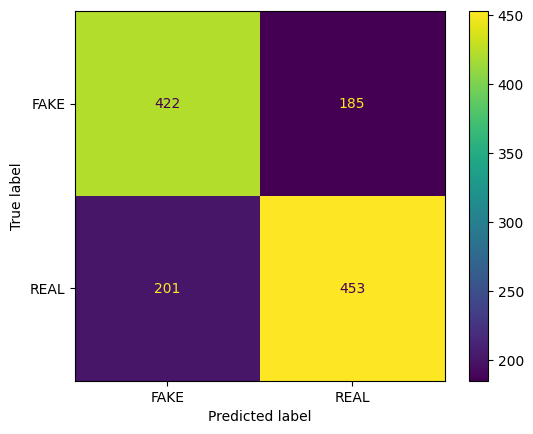

In [448]:
hyper_dict={
    'n_estimators': [50, 100, 150, 200],
    'algorithm': ['SAMME','SAMME.R'],
    'random_state': [42]
}

run_model(AdaBoostClassifier,hyper_dict)

### K-Nearest-Neighbours

This modelling method used basic logic about the *distance* between modelled data points and training data points to decide which class to assign to the given input data point. The *KNeighborsClassifier* from the *sklearn* package uses as default the $L_2$ distance metric (Minkowski Measure). The formula for the generalised $k^{\text{th}}$ measure is defined below; 

$$
L_k(p,q) := \left( \sum_{i=1}^{N} | p_i - q_i |^k \right)^{\frac{1}{k}}.
$$

MODEL METRICS
-------------

Model Parameters: {'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 4, 'weights': 'uniform'}.

Precision Score: 0.6282680081095945,
Recall Score: 0.6249008723235527,
F1 Score: 0.6256425446580955,
Accuracy Score: 0.6249008723235527,
Confusion Matrix:


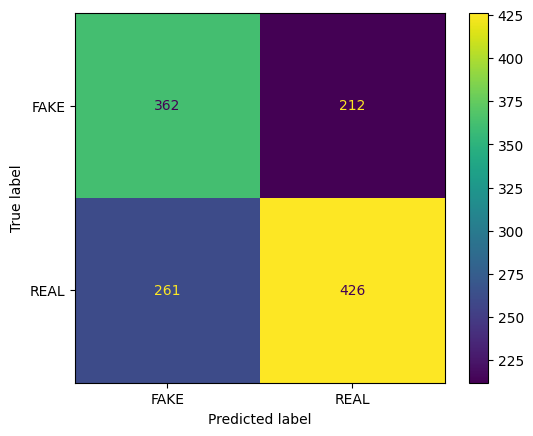

In [454]:
hyper_dict = {
    'n_neighbors': [5,6,7,8],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [2,3,4,5]
}

run_model(KNeighborsClassifier,hyper_dict) #Default Minkowski metic for distance function

### MLPClassifier (Neural Network)

MODEL METRICS
-------------

Model Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (10, 10, 10, 4), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}.

Precision Score: 0.6548050163587176,
Recall Score: 0.640761300555115,
F1 Score: 0.6435313776159475,
Accuracy Score: 0.640761300555115,
Confusion Matrix:


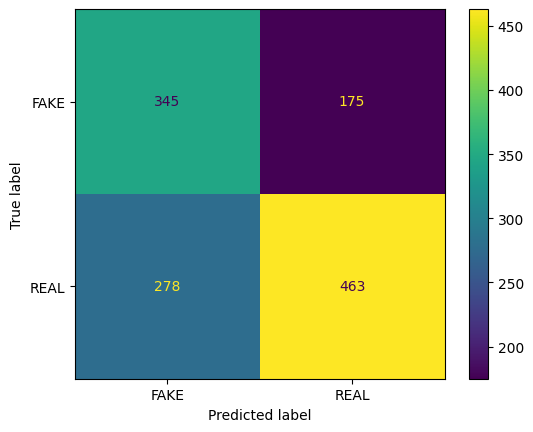

In [509]:
hyper_dict = {
    'hidden_layer_sizes': [(8,10,8,4),(10,10,10,4),(10,12,10,4)],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant','invscaling','adaptive'],
    'max_iter': [100000],
    'random_state': [42]
}

run_model(MLPClassifier,hyper_dict)